In [1]:
import os
import torch
import sys
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
parent_dir = os.path.abspath("..")
sys.path.append(parent_dir)


from src.classifying import (
    ActivationsHandler,
    get_correctness_direction_classifier
)

def extract_number(filename):
    match = re.search(r'\d+', filename)
    return int(match.group()) if match else -1

In [13]:
activations_train_path = "/home/arnau/Desktop/Cambridge/MARS/correctness-model-internals/activations/raw/mistral_7b_instruct/trivia_qa_2_60k/base/main/prompt_only/layer_20"  
activation_train_files = sorted([f for f in os.listdir(activations_train_path) if f.endswith(".pt")], key=extract_number)
activations_train_list = [torch.load(os.path.join(activations_train_path, f), map_location='cpu').cpu() for f in activation_train_files]
activations_train_raw = torch.cat(activations_train_list, dim=0)
activations_test_path = "/home/arnau/Desktop/Cambridge/MARS/correctness-model-internals/activations/raw/mistral_7b_instruct/birth_years_4k/base/main/prompt_only/layer_20"  
activation_test_files = sorted([f for f in os.listdir(activations_test_path) if f.endswith(".pt")], key=extract_number)
activations_test_list = [torch.load(os.path.join(activations_test_path, f), map_location='cpu').cpu() for f in activation_test_files]
activations_test_raw = torch.cat(activations_test_list, dim=0)
df_train = pd.read_csv("/home/arnau/Desktop/Cambridge/MARS/correctness-model-internals/evaluations/mistral_7b_instruct/trivia_qa_2_60k/base/main_generations_evaluated.csv")
labels_train = df_train["correct"].to_numpy()
df_test = pd.read_csv("/home/arnau/Desktop/Cambridge/MARS/correctness-model-internals/evaluations/mistral_7b_instruct/birth_years_4k/base/main_generations_evaluated.csv")
labels_test = df_test["correct"].to_numpy()
prompts_raw_train = df_train["prompt"].to_numpy()
prompts_raw_test = df_test["prompt"].to_numpy()
prompts_train = [prompt[483:-8] for prompt in prompts_raw_train]
prompts_test = [prompt[346:-8] for prompt in prompts_raw_test]
answers_train = df_train["answer"].to_numpy()
answers_test = df_test["answer"].to_numpy()
ground_truth_train = df_train["ground_truth"].to_numpy()
ground_truth_test = df_test["ground_truth"].to_numpy()

In [14]:
print("Train")
print("Correct:", sum(labels_train))
print("Incorrect:", len(labels_train) - sum(labels_train))
print("Total labels:", len(labels_train))
print("Percentage correct:", (sum(labels_train) / len(labels_train)) * 100)
print("Test")
print("Correct:", sum(labels_test))
print("Incorrect:", len(labels_test) - sum(labels_test))
print("Total labels:", len(labels_test))
print("Percentage correct:", (sum(labels_test) / len(labels_test)) * 100)

Train
Correct: 37101
Incorrect: 21445
Total labels: 58546
Percentage correct: 63.3706828818365
Test
Correct: 3072
Incorrect: 1358
Total labels: 4430
Percentage correct: 69.3453724604966


In [15]:
train_size = 20000
indices_correct_train = [i for i, x in enumerate(labels_train) if x == 1][:train_size]
indices_incorrect_train = [i for i, x in enumerate(labels_train) if x == 0][:train_size]
indices_train = indices_correct_train + indices_incorrect_train
activations_train = activations_train_raw[indices_train]
labels_train = torch.tensor(np.array([1 if idx in set(indices_correct_train) else 0 for idx in indices_train]), dtype=torch.bool)

In [16]:
test_size = 1300
indices_correct_test = [i for i, x in enumerate(labels_test) if x == 1][:test_size]
indices_incorrect_test = [i for i, x in enumerate(labels_test) if x == 0][:test_size]
indices_test = indices_correct_test + indices_incorrect_test
activations_test = activations_test_raw[indices_test]
labels_test = torch.tensor(np.array([1 if idx in set(indices_correct_test) else 0 for idx in indices_test]), dtype=torch.bool)

In [17]:
activations_handler_train = ActivationsHandler(
  activations=activations_train, # torch tensor of [batch, activations]
  labels=labels_train, # each row label should correspond to the row in activations_tensor
)

activations_handler_test = ActivationsHandler(
  activations=activations_test, # torch tensor of [batch, activations]
  labels=labels_test, # each row label should correspond to the row in activations_tensor
)

direction_classifier, direction_calculator = get_correctness_direction_classifier(
  activations_handler_train=activations_handler_train,
  activations_handler_test=activations_handler_test,
)

In [18]:
direction_classifier.classification_metrics

{'optimal_cut': -0.17908859252929688,
 'optimal_train_set_cut': -0.17908859252929688,
 'test_roc_auc': 0.8826289940828402,
 'accuracy_score': 0.5803846153846154,
 'f1_score': 0.7039348710990502,
 'precision_score': 0.5438155136268343,
 'recall_score': 0.9976923076923077}

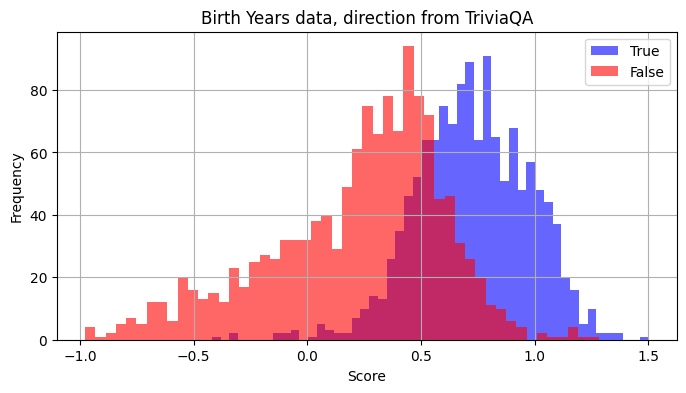

In [20]:
test_scores = direction_classifier.test_classification_score
test_classes = direction_classifier.test_labels
true_scores_test = test_scores[test_classes == 1].numpy()
false_scores_test = test_scores[test_classes == 0].numpy()   
    
# Plot distributions
plt.figure(figsize=(8, 4))
plt.hist(true_scores_test, bins=50, alpha=0.6, color='blue', label='True')
plt.hist(false_scores_test, bins=50, alpha=0.6, color='red', label='False')
plt.xlabel('Score')
plt.ylabel('Frequency')
plt.title(f'Birth Years data, direction from TriviaQA')
plt.legend()
plt.grid()
plt.show()

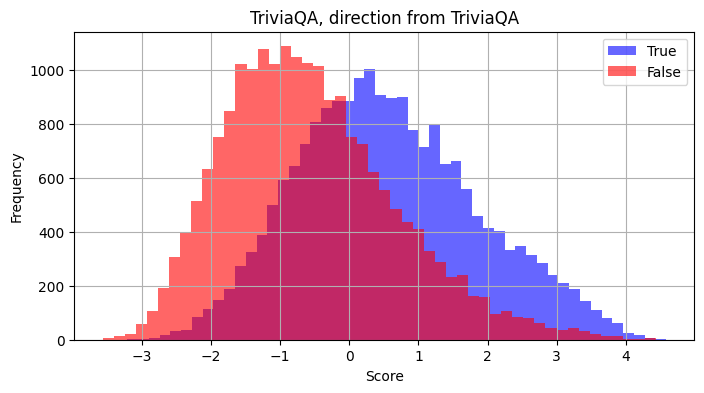

In [21]:
scores_train = direction_classifier.train_classification_score
classes_train = direction_classifier.train_labels
true_scores_train = scores_train[classes_train == 1].numpy()
false_scores_train = scores_train[classes_train  == 0].numpy()   

# Plot distributions
plt.figure(figsize=(8, 4))
plt.hist(true_scores_train, bins=50, alpha=0.6, color='blue', label='True')
plt.hist(false_scores_train, bins=50, alpha=0.6, color='red', label='False')
plt.xlabel('Score')
plt.ylabel('Frequency')
plt.title(f'TriviaQA, direction from TriviaQA')
plt.legend()
plt.grid()
plt.show()

# See prompts

In [ ]:
# Test data
n_samples = 5

# find the indices of 3 lowest scores labaled as false
false_scores_sorted = np.sort(false_scores_test)
false_scores_indices = np.argsort(false_scores_test)
print(n_samples, "on each side for false labels")
print("Low scores")
print("Scores:", false_scores_sorted[:n_samples])
print("Indices:", false_scores_indices[:n_samples])
print("Prompts:")
for i in range(n_samples):
    index = indices_incorrect_test[false_scores_indices[i]]
    print(prompts_test[index])
    print(answers_test[index])
    print(ground_truth_test[index])
print("\nHigh scores")
print("Scores:", false_scores_sorted[-n_samples:])
print("Indices:", false_scores_indices[-n_samples:])
print("Prompts:")
for i in range(n_samples):
    index = indices_incorrect_test[false_scores_indices[-n_samples + i]]
    print(prompts_test[index])
    print(answers_test[index])
    print(ground_truth_test[index])

# find the indices of 3 highest scores labeled as true
true_scores_sorted = np.sort(true_scores_test)
true_scores_indices = np.argsort(true_scores_test)
print(n_samples, "on each side for false labels")
print("Low scores")
print("Scores:", true_scores_sorted[:n_samples])
print("Indices:", true_scores_indices[:n_samples])
print("Prompts:")
for i in range(n_samples):
    index = indices_correct_test[true_scores_indices[i]]
    print(prompts_test[index])
    print(answers_test[index])
    print(ground_truth_test[index])
print("High scores")
print("Scores:", true_scores_sorted[-n_samples:])
print("Indices:", true_scores_indices[-n_samples:])
print("Prompts:")
for i in range(n_samples):
    index = indices_correct_test[true_scores_indices[-n_samples + i]]
    print(prompts_test[index])
    print(answers_test[index])
    print(ground_truth_test[index])

5 on each side for false labels
Low scores
Scores: [-0.9781469  -0.96159154 -0.9526018  -0.93659747 -0.91878164]
Indices: [1066 1180 1147  581  946]
Prompts:
What year was David Saint born?
I'm not familiar with a person named David Saint, so I can't answer that question. If you provide more context or information about who David Saint is, I may be able to help you find the answer.
1953
What year was Charles Strum born?
I don't know who Charles Strum is, so I can't answer that question.
1948
What year was Phillippi Sparks born?
I don't know who Phillippi Sparks is, so I can't answer that question.
1969
What year was Joseph Jett born?
I don't know who Joseph Jett is, so I can't answer that question.
1958
What year was Christian Peter born?
I don't have enough information to answer that question. Please provide more context or details.
1972
High scores
Scores: [1.1521084 1.1675436 1.1892734 1.1941743 1.281021 ]
Indices: [ 52 842 396 623 172]
Prompts:
What year was Drew Barrymore born?
19

In [ ]:
# Train data

scores = direction_classifier.train_classification_score

# Plot PCA

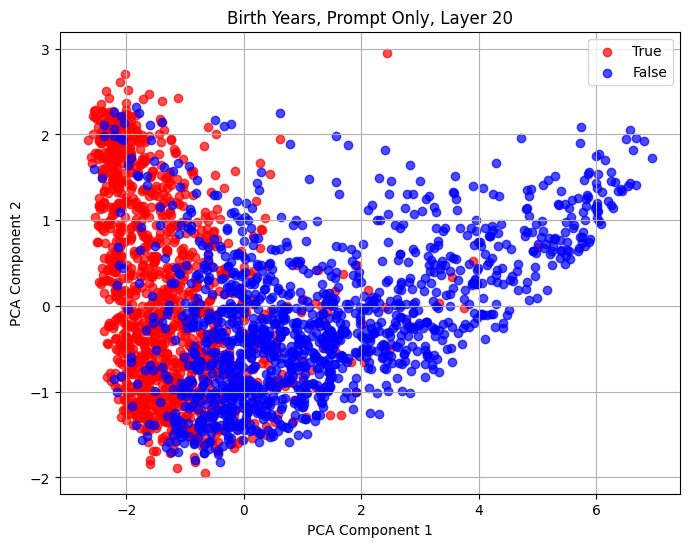

In [11]:
flat_list1_test = activations_test_raw[indices_correct_test].tolist()
flat_list2_test = activations_test_raw[indices_incorrect_test].tolist()

# Stack all data for PCA
all_data = np.vstack(flat_list1_test + flat_list2_test)

# Apply PCA to reduce to 2D
pca = PCA(n_components=2)
transformed_data = pca.fit_transform(all_data)

# Split back into two groups
split_index = len(flat_list1_test)
data1_pca = transformed_data[:split_index]
data2_pca = transformed_data[split_index:]

# Plot PCA results
plt.figure(figsize=(8, 6))
plt.scatter(data1_pca[:, 0], data1_pca[:, 1], color='red', label='True', alpha=0.7)
plt.scatter(data2_pca[:, 0], data2_pca[:, 1], color='blue', label='False', alpha=0.7)

plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("Birth Years, Prompt Only, Layer 20")
plt.legend()
plt.grid(True)
plt.show()

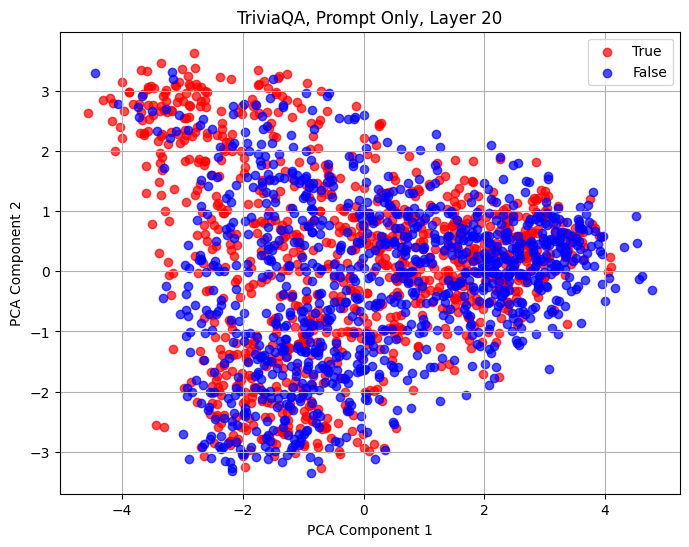

In [12]:
flat_list1_test = activations_train_raw[indices_correct_train].tolist()[:1000]
flat_list2_test = activations_train_raw[indices_incorrect_train].tolist()[:1000]

# Stack all data for PCA
all_data = np.vstack(flat_list1_test + flat_list2_test)

# Apply PCA to reduce to 2D
pca = PCA(n_components=2)
transformed_data = pca.fit_transform(all_data)

# Split back into two groups
split_index = len(flat_list1_test)
data1_pca = transformed_data[:split_index]
data2_pca = transformed_data[split_index:]

# Plot PCA results
plt.figure(figsize=(8, 6))
plt.scatter(data1_pca[:, 0], data1_pca[:, 1], color='red', label='True', alpha=0.7)
plt.scatter(data2_pca[:, 0], data2_pca[:, 1], color='blue', label='False', alpha=0.7)

plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("TriviaQA, Prompt Only, Layer 20")
plt.legend()
plt.grid(True)
plt.show()